In [1]:
import os
import sys
import numpy as np
from pathlib import Path
from torch_sparse.diag import get_diag
from torch_sparse.cat import cat
from torch_sparse import SparseTensor
from torch_sparse.reduce import reduction
from torch_sparse.mul import mul
from torch_sparse.transpose import t



if 'google.colab' in sys.modules:
  from google.colab import drive
  colab_path = '/content/'
  drive.mount('/content/drive',force_remount=True)
  DRIVE_FOLDER = Path('/content/drive/MyDrive/DataExplorationProject/Skill_Ontology_GNN')
  colab = True
else:
  colab_path = ''
  colab = False

In [269]:
import torch
from matplotlib import pyplot as plt
import gc

class Trainer:
    def __init__(self, model, criterion, optimizer, device, metrics=[]):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.metrics_history = self.create_metrics_history(metrics)
        self.epoch = 0

    def create_metrics_history(self, metrics):
        metrics = set(metrics)
        metrics.add('epoch')
        metrics.add('minibatch')
        metrics.add('accuracy')
        metrics.add('loss')

        metrics = list(metrics)
        metrics_history={}
        for split in ['train','val']:
            metrics_history[split]={}
            for metric in metrics:
                metrics_history[split][metric]=[]
        return metrics_history

    def free_memory(self):
        """Clears the GPU cache and triggers garbage collection, to reduce OOMs."""
        torch.cuda.empty_cache()
        gc.collect()

    def train(self, dataloader, n_epochs, save_interval, save_path):
        self.free_memory()
        self.model.train()
        for epoch in range(self.epoch, self.epoch+n_epochs):
            print(f'=============== Epoch {epoch} ===============')
            for batch_idx, (data, target) in enumerate(dataloader):
                data, target = data.to(self.device), target.to(self.device)
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
                self.train_losses.append(loss.item())
                if batch_idx % save_interval == 0:
                    self.save_checkpoint(epoch, batch_idx, save_path)

                print(f'Mini-Batch {batch_idx}, Loss: {loss}')

    def validate(self, dataloader):
        self.model.eval()
        with torch.no_grad():
            for data, target in dataloader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = self.criterion(output, target)
                self.val_losses.append(loss.item())




    def save_checkpoint(self, epoch, batch_idx, save_path):
        print('save')
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'metrics_history': self.metrics_history,
        }, f'{save_path}/checkpoint_{epoch}_{batch_idx}.pt')

    def load_checkpoint(self, load_path):
        checkpoint = torch.load(load_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.train_losses = checkpoint['train_losses']
        self.val_losses = checkpoint['val_losses']

    def plot_losses(self):
        plt.figure(figsize=(10,5))
        plt.title("Training and Validation Loss")
        plt.plot(self.train_losses,label="train")
        plt.plot(self.val_losses,label="val")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

In [57]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.0.1+cu118


In [58]:
if colab:
    # Install required packages.
    import os
    import torch
    os.environ['TORCH'] = torch.__version__
    print(torch.__version__)
    # !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    # !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    # !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    # !pip install git+https://github.com/pyg-team/pytorch_geometric.git
    !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
    !pip install torch_geometric
    !pip install sentence-transformers
    !pip install torcheval
    !pip install matplotlib
    !pip install pandas
    # unpack datasets
    if not 'unzipped' in globals():
        !unzip /content/drive/MyDrive/DataExplorationProject/Skill_Ontology_GNN/neo4jgraph.zip
        unzipped =True

In [59]:
import pandas as pd
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

In [60]:
# only use skill nodes which have normalized_name != NaN, this is some indication of quality skill (?)
skill_nodes = pd.read_csv(colab_path+'neo4jgraph/skills.csv').dropna(subset=['normalized_name']).reset_index()
job_nodes = pd.read_csv(colab_path+'neo4jgraph/onet_skills_unique.csv')

# drop some skills "or"
skill_nodes = skill_nodes.loc[~skill_nodes.skill.isin(['or','technology'])]

In [61]:
# There are duplicate normalized names
skill_nodes.shape[0]-skill_nodes.normalized_name.unique().shape[0]

38692

In [62]:
# There are not as many skill names which are duplicate
skill_nodes.shape[0]-skill_nodes.skill.unique().shape[0]

2483

In [63]:
# we can not use normalized name instead of skill, because it is ambiguous, e.g. communication points to different normalized names
skill_nodes.loc[skill_nodes.skill=='communication']

,index,skill,category,normalized_name
695,2229,communication,communication,Third-Party Provider Communication
1292,4059,communication,healthcare,Communication (Including SBAR)
4228,12919,communication,communication,Friendly Communication
5528,16927,communication,communication,radio/telephone communication
6311,19452,communication,communication,communication (phone and email)
...,...,...,...,...
223829,759817,communication,communication,Calling/Applying
224556,762531,communication,communication,Communication
238581,818822,communication,communication,Email/Phone Communication
245411,848577,communication,soft skills,Communication (Phone/Face-to-Face)


In [64]:
skill_nodes.drop_duplicates(subset='skill', inplace=True)

In [174]:

skill_job_edges = pd.read_csv(colab_path+'neo4jgraph/tfidf_skill_job_edge.csv')
#skill_job_edges = skill_job_edges.loc[skill_job_edges.scaled_tfidf>8]
# only use edges where we have the skill and job for from the other files
skill_job_edges = skill_job_edges.loc[skill_job_edges['skill'].isin(skill_nodes['skill'])]
skill_job_edges = skill_job_edges.loc[skill_job_edges['alt_title'].isin(job_nodes.index)]

In [103]:
skill_job_edges

,alt_title,skill,scaled_tfidf,n_jobdesc_used
1,55010,design,9.887307,240
5,55010,cg,8.744163,240
10,55010,visual effects,6.299518,240
11,55010,software,5.288013,240
12,55010,unity,5.278638,240
...,...,...,...,...
7926039,15285,analysis,6.147100,1
7926040,15285,software,6.013723,1
7926041,15285,engineering,5.864380,1
7926050,15285,development,4.434249,1


In [175]:
skillmapping ={}
for i,skill in enumerate(skill_nodes.skill.unique()):
    skillmapping[skill] =i

jobmapping ={}
for i,index in enumerate(job_nodes['index'].unique()):
    jobmapping[index] =i

inverted_skillmapping = {v:k for k,v in skillmapping.items()}
inverted_jobmapping = {v:k for k,v in jobmapping.items()}

In [176]:
skill_job_edges['skill_dst'] = skill_job_edges['skill'].apply(lambda x:skillmapping[x])
skill_job_edges['job_src'] = skill_job_edges['alt_title'].apply(lambda x:jobmapping[x])

In [177]:
# normalization and removal of job-skill edges
# first group by jobs and limit the skills for each job to 175
# then normalize those tfidf edgeweights
# then group by skill and limit edges to 125 for skills (ordered by normalized tf-idf)
skill_job_edges = skill_job_edges.groupby('job_src').apply(lambda group: group.nlargest(175,'scaled_tfidf')).reset_index(drop=True)
summed_tfidf_per_job = skill_job_edges.groupby('job_src').sum()
skill_job_edges['sum'] = skill_job_edges['job_src'].apply(lambda x: summed_tfidf_per_job.loc[x]['scaled_tfidf'])
skill_job_edges['normalized_tfidf'] =  skill_job_edges['scaled_tfidf']/skill_job_edges['sum']
skill_job_edges = skill_job_edges.groupby('skill_dst').apply(lambda group: group.nlargest(125,'normalized_tfidf')).reset_index(drop=True)

In [ ]:
# normalization and removing of skill-skill edges


In [121]:


#for each alt title select the first 125 skill_job edges, ordered by tfidf
skill_job_edges = skill_job_edges.groupby('alt_title')
skill_job_edges = skill_job_edges.groupby('alt_title').apply(lambda group: group.nlargest(125,'scaled_tfidf')).reset_index(drop=True)

# for each skill only use the 125 edges with the highest tf-idf score
#skill_job_edges = skill_job_edges.groupby('skill').apply(lambda group: group.nlargest(125,'scaled_tfidf')).reset_index(drop=True)

In [173]:
skill_job_edges

,scaled_tfidf,skill_dst,job_src,sum,normalized_tfidf
0,35.545516,126198,7,163.983794,0.216762
1,14.444801,184892,7,163.983794,0.088087
2,13.682348,115677,7,163.983794,0.083437
3,11.763047,88426,7,163.983794,0.071733
4,10.088181,221750,7,163.983794,0.061519
...,...,...,...,...,...
339405,6.736089,49534,55648,191.613717,0.035155
339406,6.629133,222265,55648,191.613717,0.034596
339407,6.265465,50164,55648,191.613717,0.032698
339408,5.501605,95122,55648,191.613717,0.028712


In [71]:
if colab:
    onet_alttitles = pd.read_csv(colab_path+'/content/neo4jgraph/onet_alt_titles_unique.csv')
else:
    onet_alttitles = pd.read_csv('neo4jgraph/onet_alt_titles_unique.csv')
del onet_alttitles['Unnamed: 0']

In [72]:
onet_alttitle_str_mapping = {}
for i,row in onet_alttitles.iterrows():
    onet_alttitle_str_mapping[row['index']] = row['Alternate Title']

In [73]:
from sentence_transformers import SentenceTransformer, util
embedder = SentenceTransformer('all-MiniLM-L6-v2')


In [74]:
# create alttitle sbert embeddings to get pca dim

alttitle_sbert_embeddings = embedder.encode(list(onet_alttitle_str_mapping.values()), convert_to_tensor=False, device='cuda')
#alttitle_sbert_indices = [k for k,v in temp]
#corpus_embeddings = util.normalize_embeddings(corpus_embeddings)

In [75]:
import numpy as np
v = alttitle_sbert_embeddings[0]
np.matmul(v.T,v)

0.99999994

In [76]:
skill_sbert_embeddings = embedder.encode(list(skillmapping.keys()), convert_to_tensor=False, device='cuda')

In [77]:

from sklearn.decomposition import PCA
X = np.concatenate([alttitle_sbert_embeddings,skill_sbert_embeddings])

# print('Original:',X.shape[1])
# for variance_retained in [0.99,0.95,0.9,0.8,0.75,0.7]:
#     pca = PCA(n_components=variance_retained)
#     pca.fit(X)
#     n_components_retained = pca.n_components_
#     print(n_components_retained,' components retained', variance_retained, ' variance retained')

In [78]:
# choose 128
pca = PCA(n_components=128)
pca.fit(X)

skill_sbert_embeddings = pca.transform(embedder.encode(skill_nodes['skill'].tolist(), convert_to_numpy=True, device='cuda'))
job_sbert_embeddings = pca.transform(embedder.encode(job_nodes['Alternate Title'].tolist(), convert_to_numpy=True, device='cuda'))

In [79]:
# add job-job edges, dataset see https://www.onetcenter.org/dictionary/26.3/excel/related_occupations.html
job_job_edges = pd.read_csv(colab_path+'neo4jgraph/onet_related_occupations.csv')

In [80]:
job_job_edges

,O*NET-SOC Code,Title,Related O*NET-SOC Code,Related Title,Relatedness Tier,index_x,index_y
0,11-1011.00,Chief Executives,11-1021.00,General and Operations Managers,Primary-Short,54641,54643
1,11-1031.00,Legislators,11-1021.00,General and Operations Managers,Supplemental,54644,54643
2,11-2021.00,Marketing Managers,11-1021.00,General and Operations Managers,Supplemental,54646,54643
3,11-2022.00,Sales Managers,11-1021.00,General and Operations Managers,Primary-Long,54647,54643
4,11-2032.00,Public Relations Managers,11-1021.00,General and Operations Managers,Primary-Long,54648,54643
...,...,...,...,...,...,...,...
18379,53-2022.00,Airfield Operations Specialists,53-2011.00,"Airline Pilots, Copilots, and Flight Engineers",Primary-Short,55590,55587
18380,53-2031.00,Flight Attendants,53-2011.00,"Airline Pilots, Copilots, and Flight Engineers",Supplemental,55591,55587
18381,53-5021.00,"Captains, Mates, and Pilots of Water Vessels",53-2011.00,"Airline Pilots, Copilots, and Flight Engineers",Primary-Short,55608,55587
18382,53-5022.00,Motorboat Operators,53-2011.00,"Airline Pilots, Copilots, and Flight Engineers",Supplemental,55609,55587


In [81]:
job_job_edges['job_src'] = job_job_edges['index_x'].apply(lambda x: jobmapping[x])
job_job_edges['job_dst'] = job_job_edges['index_y'].apply(lambda x: jobmapping[x])
relatedness_weight = {
    'Supplemental':1,
    'Primary-Long':2,
    'Primary-Short':4
}
job_job_edges['relatedness_weight'] = job_job_edges['Relatedness Tier'].apply(lambda x: relatedness_weight[x])

In [191]:
skill_skill_edges = pd.read_csv(colab_path+'neo4jgraph/skill_skill_edges.csv')


In [192]:
#filter out potentially bad skills (which are not in our original skillmapping)
skill_skill_edges = skill_skill_edges.loc[(skill_skill_edges.skill.isin(list(skillmapping.keys()))) & (skill_skill_edges.related_skill.isin(list(skillmapping.keys())))]

In [193]:
skill_skill_edges['skill_src'] = skill_skill_edges['skill'].apply(lambda x: skillmapping[x])
skill_skill_edges['skill_dst'] = skill_skill_edges['related_skill'].apply(lambda x: skillmapping[x])

In [194]:
# only take largest 125 "both directions" (not ideal)
skill_skill_edges =  skill_skill_edges.groupby('skill_src').apply(lambda group: group.nlargest(125,'cosine_sim_score')).reset_index(drop=True)
skill_skill_edges =  skill_skill_edges.groupby('skill_dst').apply(lambda group: group.nlargest(125,'cosine_sim_score')).reset_index(drop=True)

In [214]:
from torch_geometric.data import HeteroData


data = HeteroData()
data['Skill'].x = torch.tensor(skill_sbert_embeddings)
data['Job'].x = torch.tensor(job_sbert_embeddings)

data['Job','REQUIRES','Skill'].edge_index = torch.tensor(skill_job_edges[['job_src','skill_dst']].to_numpy().T)
data['Skill','IS_SIMILAR_SKILL','Skill'].edge_index = torch.tensor(skill_skill_edges[['skill_src','skill_dst']].to_numpy().T)
data['Job','IS_SIMILAR_JOB','Job'].edge_index = torch.tensor(job_job_edges[['job_src','job_dst']].to_numpy().T)


data['Job','REQUIRES','Skill'].edge_weight = torch.tensor(skill_job_edges['scaled_tfidf'].to_numpy()).to(torch.float)
data['Skill','IS_SIMILAR_SKILL','Skill'].edge_weight = torch.tensor(skill_skill_edges['cosine_sim_score'].to_numpy()).to(torch.float)
data['Job','IS_SIMILAR_JOB','Job'].edge_weight = torch.tensor(job_job_edges['relatedness_weight'].to_numpy()).to(torch.float)


In [86]:
data['Job'].x.shape

torch.Size([55653, 128])

In [184]:
skill_skill_edges_temp = skill_skill_edges

In [185]:
skill_skill_edges_temp.shape

(1273676, 7)

Jobs: 55653, actual Jobs used (in at least one edge): 16269
Skills: 247830, actual Skills used (in at least one edge): 120329

Following metrics only include Skills and Jobs with at least one edge:

JRS edges: 630303
Average JRS Job degree: 38.742576599121094, Skill: 5.238163471221924
Median JRS Job degree: 25.0, Skill: 4.0
Max JRS Job degree: 136.0, Skill: 125.0

S_SIM_S edges: 1038536
Average S_SIM_S degree: 17.261608123779297
Median S_SIM_S degree: 5.0
Max S_SIM_S degree: 250.0
J_SIM_J edges: 18384
Average J_SIM_J degree: 2.2600038051605225
Median J_SIM_J degree: 37.0
Max J_SIM_J degree: 126.0

Average total degree: Job: 41.00258255004883
Average total degree: Skill: 22.499771118164062


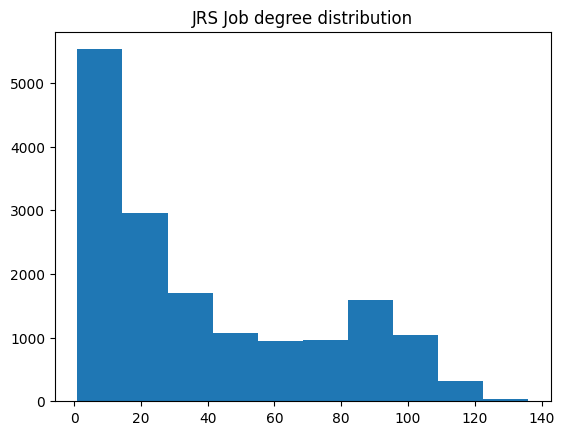

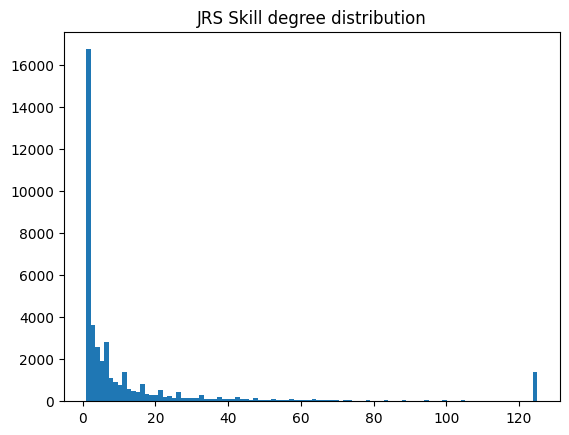

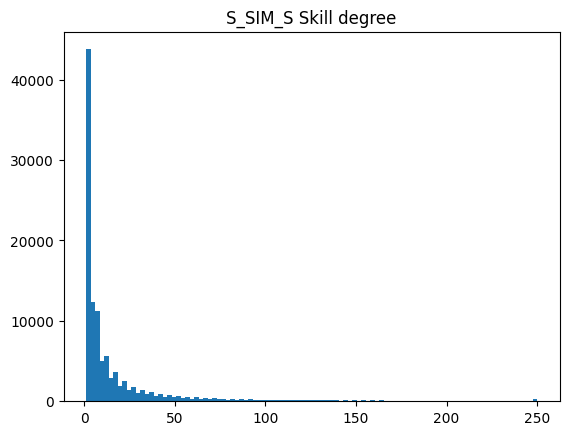

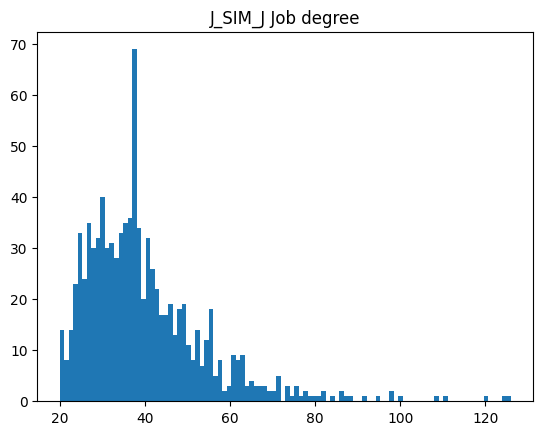

In [215]:
# Look at node degree statistics

from torch_geometric.utils import to_dense_adj, degree



job_n = data['Job'].x.shape[0]
skill_n = data['Skill'].x.shape[0]

JRS_J = degree(data['Job','REQUIRES','Skill'].edge_index[0], num_nodes=job_n)
JRS_S = degree(data['Job','REQUIRES','Skill'].edge_index[1], num_nodes=skill_n)
S_SIM_S = degree(data['Skill','IS_SIMILAR_SKILL','Skill'].edge_index.flatten(), num_nodes=skill_n)
J_SIM_J = degree(data['Job','IS_SIMILAR_JOB','Job'].edge_index.flatten(), num_nodes=job_n)

actual_skill_n = torch.nonzero(JRS_S+S_SIM_S).shape[0] # only skills which have any edge at all
actual_job_n = torch.nonzero(JRS_J+J_SIM_J).shape[0] # only job which have any edge at all
print(f'Jobs: {job_n}, actual Jobs used (in at least one edge): {actual_job_n}')
print(f'Skills: {skill_n}, actual Skills used (in at least one edge): {actual_skill_n}')

print('\nFollowing metrics only include Skills and Jobs with at least one edge:\n')

print(f"JRS edges: {data['Job','REQUIRES','Skill'].edge_index.shape[1]}")
print(f'Average JRS Job degree: {torch.sum(JRS_J)/actual_job_n}, Skill: {torch.sum(JRS_S)/actual_skill_n}')
print(f'Median JRS Job degree: {torch.median(JRS_J[JRS_J!=0])}, Skill: {torch.median(JRS_S[JRS_S!=0])}')
print(f'Max JRS Job degree: {torch.max(JRS_J)}, Skill: {torch.max(JRS_S)}\n')

print(f"S_SIM_S edges: {data['Skill','IS_SIMILAR_SKILL','Skill'].edge_index.shape[1]}")
print(f'Average S_SIM_S degree: {torch.sum(S_SIM_S)/actual_skill_n}')
print(f'Median S_SIM_S degree: {torch.median(S_SIM_S[S_SIM_S!=0])}')
print(f'Max S_SIM_S degree: {torch.max(S_SIM_S)}')

print(f'J_SIM_J edges: {data["Job", "IS_SIMILAR_JOB", "Job"].edge_index.shape[1]}')
print(f'Average J_SIM_J degree: {torch.sum(J_SIM_J)/actual_job_n}')
print(f'Median J_SIM_J degree: {torch.median(J_SIM_J[J_SIM_J!=0])}')
print(f'Max J_SIM_J degree: {torch.max(J_SIM_J)}\n')

print(f'Average total degree: Job: {(torch.sum(JRS_J)+torch.sum(J_SIM_J))/actual_job_n}')
print(f'Average total degree: Skill: {(torch.sum(JRS_S)+torch.sum(S_SIM_S))/actual_skill_n}')

import matplotlib.pyplot as plt
plt.title('JRS Job degree distribution')
plt.hist(JRS_J[JRS_J!=0], bins=10);
plt.show()
plt.title('JRS Skill degree distribution')
plt.hist(JRS_S[JRS_S!=0], bins=100);
plt.show()
plt.title('S_SIM_S Skill degree')
plt.hist(S_SIM_S[S_SIM_S!=0], bins=100);
plt.show()
plt.title('J_SIM_J Job degree')
plt.hist(J_SIM_J[J_SIM_J!=0], bins=100);
plt.show()

In [216]:
# Add features:
# - node degree
# - normalize edge weights by node degree
# - (triangle count)


# add node degree statistics:

job_degrees = torch.cat((JRS_J.reshape(-1,1) / 125, J_SIM_J.reshape(-1,1)/ 125), dim=1) # divide by approx. max degrees
skill_degrees = torch.cat((JRS_S.reshape(-1,1) / 125, S_SIM_S.reshape(-1,1)/ 125), dim=1) # divide by approx. max degrees

data['Job'].x = torch.cat((data['Job'].x, job_degrees), dim=1)
data['Skill'].x = torch.cat((data['Skill'].x, skill_degrees), dim=1)

# normalize edge weights by node degree

In [200]:
# adj_matmul
# row1 to rowS * full_matrix
# rowS+1 to rowT * full_matrix
# ....

# def blockwise_sparse_square_mmul(adj_matrix, blocks=None):
#     row_blocks = []
    
#     if blocks is None:
#         row_block_size = 10000
#         rows = adj_matrix.size(0)
#         for block in tqdm(range(0,rows, row_block_size), desc='blockwise sparse matrix-multiplication'):
#             start = block
#             end = min(block+row_block_size, rows)
#             row_blocks.append(adj_matrix[start:end].spspmm(adj_matrix))
#     else:
#         for block in tqdm(blocks, desc='blockwise sparse matrix-multiplication'):
#             row_blocks.append(block.spspmm(adj_matrix))

#     return row_blocks


# def blockwise_sparse_get_diag(blocks):
#     diags = []
#     for block in tqdm(blocks, desc='get blockwise sparse matrix diagonal'):
#         diags.append(get_diag(block))
    
#     return torch.cat(diags, dim=0)

def triangle_count(adj_matrix:SparseTensor):
    # adj_matmul, blockwise, so kernel does not crash
    # diag1((row1 to rowS) * full_matrix * full_matrix)
    # diag2((rowS+1 to rowR) * full_matrix * full_matrix)
    # ....
    diags = []
    
    row_block_size = 10000
    rows = adj_matrix.size(0)
    with torch.no_grad():
        for block in tqdm(range(0,rows, row_block_size), desc='blockwise sparse matrix-multiplication'):
            start = block
            end = min(block+row_block_size, rows)
            adj_pow_3_block = adj_matrix[start:end].spspmm(adj_matrix).spspmm(adj_matrix)
            diag_block = get_diag(adj_pow_3_block[:,start:])
            diags.append(diag_block)
            # diag = torch.eye(end)
            # indices_i, indices_j = diag.nonzero().unbind(dim=1)
            
            # A = adj_pow_2_block[indices_i]
            # B = adj_matrix[:, indices_j]
            # print(A, t(B))
            # print(type(B), type(A))
            # print(A.size(0), A.size(1), B.size(0), B.size(1))
            #C = A * t(B)
            #C = reduction(C, dim=1)
            
           
            #print(C)
            
            
            
    
    return 1/2 * torch.cat(diags, dim=0)
        
from torch_geometric.utils import to_undirected
from torch_sparse import SparseTensor
from torch_sparse.diag import get_diag

def undirected_triangle_counts(edge_index, max_num_nodes): 
    """Get triangles **per node**, to get count for whole graph, divide by 3"""
    ud = to_undirected(edge_index)
    
    adj_matrix = SparseTensor(row=ud[0], col=ud[1], value=torch.ones(ud[1].shape[0]), sparse_sizes=(max_num_nodes, max_num_nodes))
    #adj_matrix = torch.sparse_coo_tensor(edge_index, torch.ones(edge_index.shape[1]), (max_num_nodes, max_num_nodes))
    #adj_matrix = torch.sparse_csr_tensor(ud[0], ud[1], values=torch.ones(ud[1].shape[0]), dtype=torch.float32).to_sparse_coo()
    triangles = triangle_count(adj_matrix) 
    return triangles

In [90]:
# from torch_sparse import SparseTensor
# adj = torch.tensor(
#     [
#         [0,1,1,1,1],
#         [1,0,1,0,1],
#         [1,1,0,1,0],
#         [1,0,1,0,1],
#         [1,1,0,1,0]
#     ]
# ).to(torch.float)
# X = SparseTensor.from_dense(adj)
# triangles = triangle_count(X)
# triangles
#adj_matrix = SparseTensor(row=ud[0], col=ud[1], value=torch.ones(ud[1].shape[0]), sparse_sizes=(max_num_nodes, max_num_nodes))

blockwise sparse matrix-multiplication: 100%|██████████| 2/2 [00:00<00:00, 387.16it/s]

tensor([[8., 8., 8., 8., 8.],
        [8., 4., 8., 4., 8.],
        [8., 8., 4., 8., 4.]])
tensor([[8., 4., 8., 4., 8.],
        [8., 8., 4., 8., 4.]])


tensor([4., 2., 2., 2., 2.])

In [201]:
homogeneous_data = data.to_homogeneous()
homogenous_triangles = undirected_triangle_counts(homogeneous_data.edge_index, homogeneous_data.x.shape[0])
# max triangles: 9000


blockwise sparse matrix-multiplication: 100%|██████████| 31/31 [08:24<00:00, 16.28s/it]


In [232]:
Job_homogeneous_triangles = homogenous_triangles[homogeneous_data.node_type == 1]
Skill_homogeneous_triangles = homogenous_triangles[homogeneous_data.node_type != 1]

In [242]:
actual_s_triangles = Skill_homogeneous_triangles[(JRS_S+S_SIM_S)!=0] 
actual_j_triangles = Job_homogeneous_triangles[(JRS_J+J_SIM_J)!=0] 

print(f'Median triangles of skill nodes: {actual_s_triangles.median()}, mean: {actual_s_triangles.mean()}, max: {actual_s_triangles.max()}, min: {actual_s_triangles.min()}')
print(f'Median triangles of job nodes: {actual_j_triangles.median()}, mean: {actual_j_triangles.mean()}, max: {actual_j_triangles.max()}, min: {actual_s_triangles.min()}')

Median triangles of skill nodes: 3.0, mean: 119.4788818359375, max: 9285.0, min: 0.0
Median triangles of job nodes: 6.0, mean: 35.88124465942383, max: 1320.0, min: 0.0


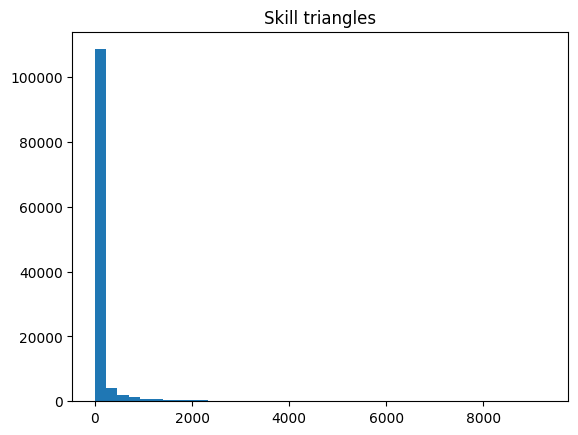

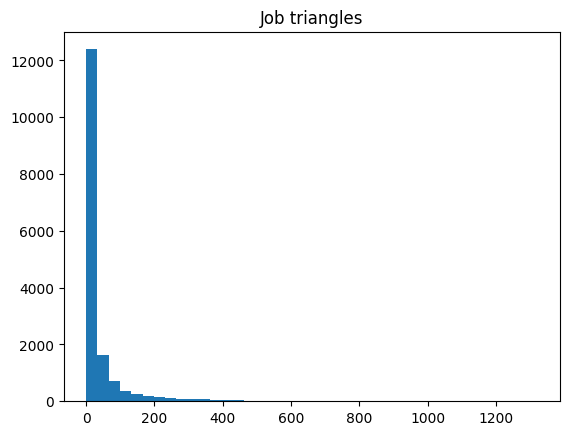

In [245]:
plt.title('Skill triangles')
plt.hist(actual_s_triangles.numpy(), bins=40)
plt.show()
plt.title('Job triangles')
plt.hist(actual_j_triangles.numpy(), bins=40)
plt.show()

In [246]:
J_SIM_J_triangles = undirected_triangle_counts(data['Job','IS_SIMILAR_JOB', 'Job'].edge_index, data['Job'].x.shape[0])
S_SIM_S_triangles = undirected_triangle_counts(data['Skill','IS_SIMILAR_SKILL', 'Skill'].edge_index, data['Skill'].x.shape[0])

blockwise sparse matrix-multiplication: 100%|██████████| 25/25 [02:55<00:00,  7.00s/it]


In [248]:
actual_s_triangles = S_SIM_S_triangles[(JRS_S+S_SIM_S)!=0] 
actual_j_triangles = J_SIM_J_triangles[(JRS_J+J_SIM_J)!=0] 

print(f'Median triangles of skill nodes for skill-skill edges: {actual_s_triangles.median()}, mean: {actual_s_triangles.mean()}, max: {actual_s_triangles.max()}, min: {actual_s_triangles.min()}')
print(f'Median triangles of job nodes for job-job edges: {actual_j_triangles.median()}, mean: {actual_j_triangles.mean()}, max: {actual_j_triangles.max()}, min: {actual_s_triangles.min()}')

Median triangles of skill nodes for skill-skill edges: 2.0, mean: 113.0720443725586, max: 7138.0, min: 0.0
Median triangles of job nodes for job-job edges: 0.0, mean: 9.882168769836426, max: 1284.0, min: 0.0


In [254]:
data['Skill'].x = torch.cat((data['Skill'].x, Skill_homogeneous_triangles.reshape(-1,1)/9285), dim=1) # normalize by max 9285.0
data['Job'].x = torch.cat((data['Job'].x, Job_homogeneous_triangles.reshape(-1,1)/1320), dim=1) # normalize by max 1320

data['Skill'].x = torch.cat((data['Skill'].x, S_SIM_S_triangles.reshape(-1,1)/9285), dim=1) # normalize by max 9285.0
data['Job'].x = torch.cat((data['Job'].x, J_SIM_J_triangles.reshape(-1,1)/1320), dim=1) # normalize by max 1320

In [257]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [258]:
data.has_isolated_nodes(), data.has_self_loops()

(True, False)

In [ ]:
#data = data.to(device)

In [ ]:
import torch_geometric.transforms as T

transform = T.Compose([
       T.RemoveIsolatedNodes(),
       T.RemoveDuplicatedEdges(),
       T.ToUndirected(merge=False) # don't merge reversed edges into the original edge type
])

data = transform(data)


In [62]:
import os
import torch

filename = 'Job_Skill_HeteroData_v1.pt'
if os.path.exists('./'+filename):
    data = torch.load('./'+filename)
    print('loading saved heterodata object')
else:
    torch.save(data, './'+filename)

loading saved heterodata object


In [101]:
transform = T.RandomLinkSplit(
    is_undirected=True,
    edge_types=[
        ('Job', 'REQUIRES', 'Skill'),
        ('Skill', 'IS_SIMILAR_SKILL', 'Skill'),
        ('Job', 'IS_SIMILAR_JOB', 'Job')
        ],
    rev_edge_types=[
        ('Skill', 'rev_REQUIRES', 'Job'),
        ('Skill', 'rev_IS_SIMILAR_SKILL', 'Skill'),
        ('Job', 'rev_IS_SIMILAR_JOB', 'Job')
    ],
    num_val=0.008,
    num_test=0.0008,
    add_negative_train_samples=False, # only adds neg samples for val and test, neg train are added by LinkNeighborLoader. This means for each train batch, negs. are different, for val and train they stay the same
    neg_sampling_ratio=1.0,
    disjoint_train_ratio=0 #  training edges are shared for message passing and supervision

    )
train_data, val_data, test_data = transform(data)

In [102]:
train_data

HeteroData(
  Skill={ x=[120329, 132] },
  Job={ x=[16269, 132] },
  (Job, REQUIRES, Skill)={
    edge_index=[2, 624757],
    edge_weight=[624757],
    edge_label=[624757],
    edge_label_index=[2, 624757]
  },
  (Skill, IS_SIMILAR_SKILL, Skill)={
    edge_index=[2, 1029398],
    edge_weight=[1029398],
    edge_label=[1029398],
    edge_label_index=[2, 1029398]
  },
  (Job, IS_SIMILAR_JOB, Job)={
    edge_index=[2, 18223],
    edge_weight=[18223],
    edge_label=[18223],
    edge_label_index=[2, 18223]
  },
  (Skill, rev_REQUIRES, Job)={
    edge_index=[2, 624757],
    edge_weight=[624757]
  },
  (Skill, rev_IS_SIMILAR_SKILL, Skill)={
    edge_index=[2, 1029398],
    edge_weight=[1029398]
  },
  (Job, rev_IS_SIMILAR_JOB, Job)={
    edge_index=[2, 18223],
    edge_weight=[18223]
  }
)

In [76]:
train_data

HeteroData(
  Skill={ x=[120329, 132] },
  Job={ x=[16269, 132] },
  (Job, REQUIRES, Skill)={
    edge_index=[2, 629295],
    edge_weight=[629295],
    edge_label=[629295],
    edge_label_index=[2, 629295]
  },
  (Skill, IS_SIMILAR_SKILL, Skill)={
    edge_index=[2, 1036876],
    edge_weight=[1036876],
    edge_label=[1036876],
    edge_label_index=[2, 1036876]
  },
  (Job, IS_SIMILAR_JOB, Job)={
    edge_index=[2, 18356],
    edge_weight=[18356],
    edge_label=[18356],
    edge_label_index=[2, 18356]
  },
  (Skill, rev_REQUIRES, Job)={
    edge_index=[2, 629295],
    edge_weight=[629295]
  },
  (Skill, rev_IS_SIMILAR_SKILL, Skill)={
    edge_index=[2, 1036876],
    edge_weight=[1036876]
  },
  (Job, rev_IS_SIMILAR_JOB, Job)={
    edge_index=[2, 18356],
    edge_weight=[18356]
  }
)

In [ ]:
# from torch_geometric.loader import NeighborLoader

# train_loader = NeighborLoader(
#     train_data,
#     # Sample 15 neighbors for each node and each edge type for 2 iterations:
#     num_neighbors={
#          ('Job', 'REQUIRES', 'Skill'):[1000,10], # [add x neighbors, add y neighbors for every x neighbor]
#          ('Skill', 'rev_REQUIRES', 'Job'):[10,0],
#         ('Skill', 'IS_SIMILAR_SKILL', 'Skill'):[10,10],
#         ('Skill', 'rev_IS_SIMILAR_SKILL', 'Skill'):[0,0],
#         ('Job', 'IS_SIMILAR_JOB', 'Job'):[0,20], # can't sample job-job in first iteration
#         ('Job', 'rev_IS_SIMILAR_JOB', 'Job'):[0,20],
#          },
#     # num_neighbors = [10,10],
#     # Use a batch size of 128 for sampling training nodes of type "paper":
#     batch_size=200,
#     input_nodes='Job', #if not set, we consider all nodes
#     shuffle=True,
#     drop_last=True,
#     num_workers=4,
#     directed=True,  # contains only edges which are followed randomly, False: contains full node induced subgraph
# )


In [75]:
val_data

HeteroData(
  Skill={ x=[120329, 132] },
  Job={ x=[16269, 132] },
  (Job, REQUIRES, Skill)={
    edge_index=[2, 629295],
    edge_weight=[629295],
    edge_label=[1008],
    edge_label_index=[2, 1008]
  },
  (Skill, IS_SIMILAR_SKILL, Skill)={
    edge_index=[2, 1036876],
    edge_weight=[1036876],
    edge_label=[1660],
    edge_label_index=[2, 1660]
  },
  (Job, IS_SIMILAR_JOB, Job)={
    edge_index=[2, 18356],
    edge_weight=[18356],
    edge_label=[28],
    edge_label_index=[2, 28]
  },
  (Skill, rev_REQUIRES, Job)={
    edge_index=[2, 629295],
    edge_weight=[629295]
  },
  (Skill, rev_IS_SIMILAR_SKILL, Skill)={
    edge_index=[2, 1036876],
    edge_weight=[1036876]
  },
  (Job, rev_IS_SIMILAR_JOB, Job)={
    edge_index=[2, 18356],
    edge_weight=[18356]
  }
)

In [59]:
train_data

HeteroData(
  Skill={ x=[120329, 132] },
  Job={ x=[16269, 132] },
  (Job, REQUIRES, Skill)={
    edge_index=[2, 629295],
    edge_weight=[629295],
    edge_label=[629295],
    edge_label_index=[2, 629295]
  },
  (Skill, IS_SIMILAR_SKILL, Skill)={
    edge_index=[2, 1090870],
    edge_weight=[1090870],
    edge_label=[545435],
    edge_label_index=[2, 545435]
  },
  (Job, IS_SIMILAR_JOB, Job)={
    edge_index=[2, 18562],
    edge_weight=[18562],
    edge_label=[9281],
    edge_label_index=[2, 9281]
  },
  (Skill, rev_REQUIRES, Job)={
    edge_index=[2, 630303],
    edge_weight=[630303]
  },
  (Skill, rev_IS_SIMILAR_SKILL, Skill)={
    edge_index=[2, 1038536],
    edge_weight=[1038536]
  },
  (Job, rev_IS_SIMILAR_JOB, Job)={
    edge_index=[2, 18384],
    edge_weight=[18384]
  }
)

In [57]:
from itertools import cycle
from typing import Tuple, List, Union
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.sampler import NegativeSampling
from torch_geometric.data import HeteroData

def create_loader(data:HeteroData, edge_type:Tuple[str,str,str], num_neighbors:List[int], negative_sampling_amount:int, batch_size:int, is_training:bool)->LinkNeighborLoader:

    #print('create mini-batches for', edge)

    negative_sampling = NegativeSampling(
        mode='binary',
        amount=negative_sampling_amount  # ratio, like Graphsage
        #weight=  # "Probabilities" of nodes to be sampled: Node degree follows power law distribution
        )

    loader = LinkNeighborLoader(
        data,
        num_neighbors={
            ('Job', 'REQUIRES', 'Skill'):num_neighbors,
            ('Skill', 'rev_REQUIRES', 'Job'):num_neighbors,
            ('Skill', 'IS_SIMILAR_SKILL', 'Skill'):num_neighbors, # In this example, index 0 will never be used, since neighboring edge to a job node can't be a skill-skill edge
            ('Skill', 'rev_IS_SIMILAR_SKILL', 'Skill'):num_neighbors,
            ('Job', 'IS_SIMILAR_JOB', 'Job'):num_neighbors,
            ('Job', 'rev_IS_SIMILAR_JOB', 'Job'):num_neighbors,
        },
        edge_label_index=(edge_type, data[edge_type].edge_label_index), # if (edge, None), None means all edges are considered
        #edge_label =train_data[edge].edge_label,
        neg_sampling=negative_sampling, # adds negative samples
        batch_size=batch_size,
        shuffle=is_training,
        #drop_last=True,
        num_workers=2,
        directed=True,  # contains only edges which are followed, False: contains full node induced subgraph
        #disjoint=True # sampled seed node creates its own, disjoint from the rest, subgraph, will add "batch vector" to loader output
    )

    return loader


batch_size=256
num_neighbors = [5,4]

train_loaders, val_loaders, test_loaders = [], [], []
for edge_type in train_data.edge_types:
    # create mini-batches for each edge type, because LinkNeighborLoader only allows one target edge type
    print(edge_type)
    datasets = {
        'train':train_data,
        'val': val_data,
        'test': test_data
    }
    loader = create_loader(
        data=train_data,
        edge_type=edge_type,
        num_neighbors=num_neighbors,
        batch_size=batch_size,
        is_training=True,
        negative_sampling_amount=20
    )
    train_loaders.append(loader)

    loader = create_loader(
        data=val_data,
        edge_type=edge_type,
        num_neighbors=num_neighbors,
        batch_size=batch_size,
        is_training=False,
        negative_sampling_amount=1
    )

    val_loaders.append(loader)

    loader = create_loader(
        data=test_data,
        edge_type=edge_type,
        num_neighbors=num_neighbors,
        batch_size=batch_size,
        is_training=False,
        negative_sampling_amount=1
    )

    test_loaders.append(loader)

print(f'Largest Train Batch Object: {max([len(loader) for loader in train_loaders])}')
print(f'Largest Val Batch Object: {max([len(loader) for loader in val_loaders])}')
print(f'Largest Test Batch Object: {max([len(loader) for loader in test_loaders])}')

def combined_iterator(iterables):
  # creates an iterator which has as many elements as the longest iterable
  # other iterables will be repeated until the longest is done
  length = 0
  index = 0
  for i, iterable in enumerate(iterables):
    l = len(iterable)
    if l>length:
      length = l
      index = i

  longest_iterable = iterables.pop(index)
  iterators = [longest_iterable] + [cycle(it) for it in iterables]
  return zip(*iterators)


train_iterator = combined_iterator(train_loaders)
val_iterator = combined_iterator(val_loaders)
test_iterator = combined_iterator(test_loaders)

('Job', 'REQUIRES', 'Skill')
('Skill', 'IS_SIMILAR_SKILL', 'Skill')
('Job', 'IS_SIMILAR_JOB', 'Job')
('Skill', 'rev_REQUIRES', 'Job')


AttributeError: 'EdgeStorage' object has no attribute 'edge_label_index'

In [55]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], edge_label_index=[200])

In [50]:
import numpy as np
data.edge_label_index = torch.tensor(np.arange(200))

In [51]:
loader = LinkNeighborLoader(
    data,
    # Sample 30 neighbors for each node for 2 iterations
    num_neighbors=[30] * 2,
    # Use a batch size of 128 for sampling training nodes
    batch_size=128,
    edge_label_index=data.edge_index,
)

sampled_data = next(iter(loader))
print(sampled_data)
len(loader)

Data(x=[1395, 1433], edge_index=[2, 3129], y=[1395], edge_label_index=[2, 128], n_id=[1395], e_id=[3129], input_id=[128])


83

In [48]:
10556/128

82.46875

In [35]:
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import LinkNeighborLoader

data = Planetoid('x', name='Cora')[0]




Data(x=[1374, 1433], edge_index=[2, 3111], y=[1374], train_mask=[1374], val_mask=[1374], test_mask=[1374], n_id=[1374], e_id=[3111], input_id=[128], edge_label_index=[2, 128])


Processing...
Done!


In [32]:
for i, x in enumerate(val_loaders[0]):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [30]:
len(val_loaders[0])

2459

In [27]:
next(iter(val_loaders[0]))

HeteroData(
  Skill={
    x=[22990, 132],
    n_id=[22990]
  },
  Job={
    x=[7858, 132],
    n_id=[7858]
  },
  (Job, REQUIRES, Skill)={
    edge_index=[2, 13365],
    edge_weight=[13365],
    edge_label=[512],
    edge_label_index=[2, 512],
    e_id=[13365],
    input_id=[256]
  },
  (Skill, IS_SIMILAR_SKILL, Skill)={
    edge_index=[2, 17047],
    edge_weight=[17047],
    edge_label=[874],
    edge_label_index=[2, 874],
    e_id=[17047]
  },
  (Job, IS_SIMILAR_JOB, Job)={
    edge_index=[2, 1197],
    edge_weight=[1197],
    edge_label=[14],
    edge_label_index=[2, 14],
    e_id=[1197]
  },
  (Skill, rev_REQUIRES, Job)={
    edge_index=[2, 8179],
    edge_weight=[8179],
    e_id=[8179]
  },
  (Skill, rev_IS_SIMILAR_SKILL, Skill)={
    edge_index=[2, 15547],
    edge_weight=[15547],
    e_id=[15547]
  },
  (Job, rev_IS_SIMILAR_JOB, Job)={
    edge_index=[2, 1198],
    edge_weight=[1198],
    e_id=[1198]
  }
)

In [39]:
val_data

HeteroData(
  Skill={ x=[120329, 132] },
  Job={ x=[16269, 132] },
  (Job, REQUIRES, Skill)={
    edge_index=[2, 629295],
    edge_weight=[629295],
    edge_label=[1008],
    edge_label_index=[2, 1008]
  },
  (Skill, IS_SIMILAR_SKILL, Skill)={
    edge_index=[2, 1090870],
    edge_weight=[1090870],
    edge_label=[874],
    edge_label_index=[2, 874]
  },
  (Job, IS_SIMILAR_JOB, Job)={
    edge_index=[2, 18562],
    edge_weight=[18562],
    edge_label=[14],
    edge_label_index=[2, 14]
  },
  (Skill, rev_REQUIRES, Job)={
    edge_index=[2, 630303],
    edge_weight=[630303]
  },
  (Skill, rev_IS_SIMILAR_SKILL, Skill)={
    edge_index=[2, 1038536],
    edge_weight=[1038536]
  },
  (Job, rev_IS_SIMILAR_JOB, Job)={
    edge_index=[2, 18384],
    edge_weight=[18384]
  }
)

In [28]:
next(iter(train_loaders[0]))

HeteroData(
  Skill={
    x=[59922, 132],
    n_id=[59922]
  },
  Job={
    x=[13013, 132],
    n_id=[13013]
  },
  (Job, REQUIRES, Skill)={
    edge_index=[2, 53312],
    edge_weight=[53312],
    edge_label=[5376],
    edge_label_index=[2, 5376],
    e_id=[53312],
    input_id=[256]
  },
  (Skill, IS_SIMILAR_SKILL, Skill)={
    edge_index=[2, 87637],
    edge_weight=[87637],
    edge_label=[545435],
    edge_label_index=[2, 545435],
    e_id=[87637]
  },
  (Job, IS_SIMILAR_JOB, Job)={
    edge_index=[2, 3755],
    edge_weight=[3755],
    edge_label=[9281],
    edge_label_index=[2, 9281],
    e_id=[3755]
  },
  (Skill, rev_REQUIRES, Job)={
    edge_index=[2, 36613],
    edge_weight=[36613],
    e_id=[36613]
  },
  (Skill, rev_IS_SIMILAR_SKILL, Skill)={
    edge_index=[2, 76085],
    edge_weight=[76085],
    e_id=[76085]
  },
  (Job, rev_IS_SIMILAR_JOB, Job)={
    edge_index=[2, 3761],
    edge_weight=[3761],
    e_id=[3761]
  }
)

In [ ]:
# helpful article
# https://medium.com/stanford-cs224w/a-tour-of-pygs-data-loaders-9f2384e48f8f

# some info

# HeteroData(
#   Job={
#     x=[9222, 128], # node features
#     n_id=[9222] # the ids of the nodes in the original train_data set
#   },
#   (Job, REQUIRES, Skill)={
#     edge_index=[2, 14498], # sampled edges
#     edge_attr=[14498, 1],  # edge attributes of sampled edges
#     edge_label=[509170], # 1 if it is a true edge, 0 if it is a false
#     edge_label_index=[2, 509170], # all edges?
#     e_id=[14498] # edge ids of edges in the original train_data set



# if batchsize is 16 for the edge and we have neg_sampling=binary, we will have
# this many jobs:
#  Job={
#     x=[64, 128],
#     n_id=[64]
#   },
# since we sample a negative and a positive edge each, and each edge has 2 Job nodes (if our target is the job nodes)

# LinkNeighborloader will sample negative edges for the target edges only, as we expect it
# so for the "neighbor"-edges we get only positive ones

In [265]:
from typing import Tuple, Union
from torch import Tensor
from torch_geometric.nn import to_hetero, HeteroDictLinear, Linear
from torch_geometric.nn.conv import GraphConv, SAGEConv, SimpleConv
import torch.nn.functional as F
from torch_geometric.typing import Adj, OptPairTensor, OptTensor, Size




# PyG does not implement the exact max pooling aggregation as in the GraphSage paper
# with GraphConvWithPool we manually extend it by adding a linear layer on x before .propagate
# as our activation function is monotonically increasing, this modification corresponds to the max pooling aggregation

class GraphConvWithPool(GraphConv):
    def __init__(self, in_channels, out_channels: int, aggr: str = 'add', bias: bool = True, **kwargs):
        super().__init__(in_channels, out_channels, aggr, bias, **kwargs)
        self.linear = torch.nn.Linear(in_channels, in_channels, bias=False)

    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_weight: OptTensor = None, size: Size = None) -> Tensor:

        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        x = self.linear(x) # added this

        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=size)
        out = self.lin_rel(out)

        x_r = x[1]
        if x_r is not None:
            out = out + self.lin_root(x_r)

        return out



class WeightedSkillSage(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, aggregator='max'):
        super().__init__()
        #self.linear1 = Linear(-1,-1)
        #self.conv1 = SimpleConv(aggr='sum')
        self.conv1 = GraphConv(in_channels=-1, out_channels=hidden_channels)
        self.conv2 = GraphConv(in_channels=hidden_channels, out_channels=hidden_channels)
        self.linear3 = Linear(hidden_channels,out_channels)

    def forward(self, x: HeteroData, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = self.linear3(x)
        return x

model = WeightedSkillSage(hidden_channels=64, out_channels=64)
model = to_hetero(model, train_data.metadata(), aggr='sum')


In [270]:
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryAUPRC

class GNNTrainer(Trainer):
    def __init__(self, model, criterion, optimizer, device):
        super().__init__(model, criterion, optimizer, device, metrics=['f1','accuracy','precision','recall', 'aucpr'])

    def get_supervision_edge_type(self, heterodata):
        for edge_type in heterodata.edge_types:
            if 'input_id' in heterodata[edge_type].keys():
                return edge_type

    def calculate_metrics(self, split_name, y_hat, y):
        y = y.to(torch.int)
        acc, prec, rec, f1, aucpr = BinaryAccuracy(threshold=0.5).update(y_hat, y).compute().item(), BinaryPrecision(threshold=0.5).update(y_hat, y).compute().item(), BinaryRecall(threshold=0.5).update(y_hat, y).compute().item(), BinaryF1Score(threshold=0.5).update(y_hat, y).compute().item(), BinaryAUPRC().update(y_hat, y).compute().item()
        '''  self.metrics_history[split_name]['accuracy'].append(acc)
        self.metrics_history[split_name]['precision'].append(prec)
        self.metrics_history[split_name]['recall'].append(rec)
        self.metrics_history[split_name]['f1'].append(f1)
        self.metrics_history[split_name]['aucpr'].append(aucpr) '''
        print(f'{split_name}: F1: {f1}, AUC-PR: {aucpr}, (acc: {acc}, prec: {prec}, rec: {rec})')

    def train(self, train_iterator, val_iterator, start_epoch, n_epochs, save_interval, save_path):
        train_size = train_iterator
        print(f'Train batch size: {}')
        self.free_memory()

        self.model.train()
        for epoch in range(start_epoch, start_epoch+n_epochs):
            print(f'=============== Epoch {epoch} ===============')
            for batch_idx, edge_batches in enumerate(train_iterator):
                self.optimizer.zero_grad()
                minibatch_loss = 0

                y_hat, y = [], []
                for i,batch in enumerate(edge_batches):  # each batch here is one edge type, since we want to learn for all edge types
                    print(i,end='\r')
                    batch = batch.to(self.device)
                    hetero_out = model(batch.x_dict, batch.edge_index_dict, batch.edge_weight_dict)  # get model output

                    # evaluate, calculate cosine sim and compute cross-entropy loss
                    supervision_edge_type = self.get_supervision_edge_type(batch)
                    src_type, dst_type = supervision_edge_type[0], supervision_edge_type[2]
                    edge_label = batch[supervision_edge_type].edge_label
                    edge_label_index = batch[supervision_edge_type].edge_label_index
                    src_node_embeddings = hetero_out[src_type][edge_label_index[0]]
                    dst_node_embeddings = hetero_out[dst_type][edge_label_index[1]]
                    logits = F.cosine_similarity(src_node_embeddings, dst_node_embeddings, dim=-1)
                    loss = self.criterion(logits, edge_label)
                    minibatch_loss += loss

                    y_hat.append(torch.sigmoid(logits))
                    y.append(edge_label)

                minibatch_loss.backward()
                self.optimizer.step()

                # save loss and metrics
                self.metrics_history['train']['minibatch'].append(epoch+batch_idx)
                self.metrics_history['train']['epoch'].append(epoch+batch_idx)
                self.metrics_history['train']['loss'].append(minibatch_loss.item())

                y_hat = torch.cat(y_hat)
                y = torch.cat(y)
                print("aa")
                self.calculate_metrics('train', y_hat, y)

                if batch_idx % save_interval == 0:
                    print('bb')
                    self.free_memory()
                    self.validate(val_iterator, epoch)
                    print('save')
                    self.save_checkpoint(epoch, batch_idx, save_path)

                print(f'Mini-Batch {batch_idx}, Loss: {loss}')

    def validate(self, val_iterator, epoch):
        self.model.eval()
        with torch.no_grad():
          y_hat, y = [], []
          for edge_batches in tqdm(val_iterator):

              for batch in edge_batches:  # each batch here is one edge type, since we want to learn for all edge types

                    batch = batch.to(self.device)
                    hetero_out = model(batch.x_dict, batch.edge_index_dict, batch.edge_weight_dict)  # get model output

                    # evaluate, calculate cosine sim and compute cross-entropy loss
                    supervision_edge_type = self.get_supervision_edge_type(batch)
                    src_type, dst_type = supervision_edge_type[0], supervision_edge_type[2]
                    edge_label = batch[supervision_edge_type].edge_label
                    edge_label_index = batch[supervision_edge_type].edge_label_index
                    src_node_embeddings = hetero_out[src_type][edge_label_index[0]]
                    dst_node_embeddings = hetero_out[dst_type][edge_label_index[1]]
                    logits = F.cosine_similarity(src_node_embeddings, dst_node_embeddings, dim=-1)

                    y_hat.append(torch.sigmoid(logits))
                    y.append(edge_label)


          # save loss and metrics
          self.metrics_history['val']['epoch'].append(epoch)

          y_hat = torch.cat(y_hat)
          y = torch.cat(y)
          self.calculate_metrics('val', y_hat, y)

In [271]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
criterion = torch.nn.CrossEntropyLoss()
model = model.to(device)
trainer = GNNTrainer(model, criterion, optimizer, device)







trainer.train(train_iterator, val_iterator, start_epoch=0, n_epochs=10, save_interval=1, save_path='./checkpoints')
# trainer.validate(val_dataloader)
# trainer.plot_losses()
# trainer.load_checkpoint('./checkpoints/checkpoint_100.pt')

=============== Epoch 0 ===============
aa
train: F1: 0.07607337087392807, AUC-PR: 0.05115339905023575, (acc: 0.1520647257566452, prec: 0.04011828824877739, rec: 0.7330729365348816)
bb


18it [00:25,  1.39s/it]


KeyboardInterrupt: 

In [285]:
len(train_loaders[4])

72

In [273]:
len(train_iterator)

TypeError: 'zip' object is not subscriptable

In [ ]:
import gc
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"
# with torch.no_grad():  # Initialize lazy modules.
#      out = model(batch.x_dict, batch.edge_index_dict, batch.edge_weight_dict)
def get_supervision_edge_type(heterodata):
    for edge_type in heterodata.edge_types:
        if 'input_id' in heterodata[edge_type].keys():
            return edge_type





optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
loss_fn = torch.nn.CrossEntropyLoss()
model.train()
for edge_batches in train_iterator:
    minibatch_loss = 0


    # each batch here is one edge type, since we want to learn for all edge types
    for batch in edge_batches:
        batch = batch.to(device)
        hetero_out = model(batch.x_dict, batch.edge_index_dict, batch.edge_weight_dict)

        supervision_edge_type = get_supervision_edge_type(batch)
        src_type, dst_type = supervision_edge_type[0], supervision_edge_type[2]
        edge_label = batch[supervision_edge_type].edge_label
        edge_label_index = batch[supervision_edge_type].edge_label_index
        src_node_embeddings = hetero_out[src_type][edge_label_index[0]]
        dst_node_embeddings = hetero_out[dst_type][edge_label_index[1]]
        logits = F.cosine_similarity(src_node_embeddings, dst_node_embeddings, dim=-1)
        loss = loss_fn(logits, edge_label)
        minibatch_loss += loss

    minibatch_loss.backward()
    optimizer.step()

    print('mini-batch loss:',float(batch_loss))





In [ ]:
supervision_edge_type = get_supervision_edge_type(batch)
src_type, dst_type = supervision_edge_type[0], supervision_edge_type[2]
edge_label = batch[supervision_edge_type].edge_label
edge_label_index = batch[supervision_edge_type].edge_label_index
src_node_embeddings = out[src_type][edge_label_index[0]]
dst_node_embeddings = out[dst_type][edge_label_index[1]]
torch.min(F.cosine_similarity(src_node_embeddings, dst_node_embeddings, dim=-1))

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
batch[supervision_edge_type].edge_label_index

In [ ]:
J2S = ('Job','REQUIRES','Skill')
batch[J2S].edge_label_index

In [ ]:
batch['Job','REQUIRES','Skill'].

In [ ]:
batch = next(iter(train_loaders[0]))


In [ ]:
batch

In [ ]:
batch.edge_weight_dict

In [ ]:
index = batch['Job','IS_SIMILAR_JOB','Job'].e_id
labels = batch['Job','IS_SIMILAR_JOB','Job'].edge_label

In [ ]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import SAGEConv, to_hetero


dataset = OGB_MAG(root='./data', preprocess='metapath2vec', transform=T.ToUndirected())
data = dataset[0]

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(-1, hidden_channels)
        self.conv2 = SAGEConv(-1, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


model = GNN(hidden_channels=64, out_channels=dataset.num_classes)
model = to_hetero(model, data.metadata(), aggr='sum')

In [ ]:
#https://colab.research.google.com/drive/1GrAxHyZCZ13jpTkMy9vVO_v_U9nHDdvB#scrollTo=wmiFKI0ovYN4


In [ ]:
# intially we use this GraphConv layer and aggregate using mean
# this layer allows the addition of edge weights: the adjacency matrix simply consists not of 1s and 0s but the corresponding weights
#https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GraphConv.html

# using max pool
# https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.global_max_pool.html#torch_geometric.nn.pool.global_max_pool